# Logisitc regression from scratch

`Goal: Classifying MNIST between digits with circles (0,6,8,9) or without circles (1,2,3,4,5,7)`

### Loading the MNIST dataset

In [3]:
import gzip
import os
import numpy as np
import struct


def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, f'{kind}-labels-idx1-ubyte.gz')
    images_path = os.path.join(path, f'{kind}-images-idx3-ubyte.gz')

    with gzip.open(labels_path, 'rb') as lbpath:
        _, _ = struct.unpack('>II', lbpath.read(8))
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8)

    with gzip.open(images_path, 'rb') as imgpath:
        _, num, rows, cols = struct.unpack('>IIII', imgpath.read(16))
        images = np.frombuffer(imgpath.read(), dtype=np.uint8).reshape(num, rows*cols)

    return images, labels

In [24]:
# Load the dataset

mnist_path = '../../../supplemental_material/MNIST'
X_train, y_train = load_mnist(mnist_path, kind='train')
X_test, y_test = load_mnist(mnist_path, kind='t10k')

print(f"Training set shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Test set shape: {X_test.shape}, Test labels shape: {y_test.shape}")

Training set shape: (60000, 784), Training labels shape: (60000,)
Test set shape: (10000, 784), Test labels shape: (10000,)


### Classify digits with or without circles using Logistic Regression

In [25]:
from sklearn.preprocessing import StandardScaler


# Define the digits with and without circles
circle_digits = [0, 6, 8, 9]
no_circle_digits = [1, 2, 3, 4, 5, 7]

# Filter the training and test sets to include only the relevant digits
train_mask = np.isin(y_train, circle_digits + no_circle_digits)
X_train, y_train = X_train[train_mask], y_train[train_mask]

test_mask = np.isin(y_test, circle_digits + no_circle_digits)
X_test, y_test = X_test[test_mask], y_test[test_mask]

y_train_binary = np.where(np.isin(y_train, circle_digits), 1, 0)
y_test_binary = np.where(np.isin(y_test, circle_digits), 1, 0)



# Normalize the data (important for gradient descent)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

The formula for logistic regression is:

$$
P(y = 1 \mid X) = \sigma(w^T X + b) = \frac{1}{1 + e^{-(w^T X + b)}}
$$

where:
- $P(y = 1 \mid X)$ is the probability that the output $y$ is 1 given the input features $X$.
- $\sigma(z) = \frac{1}{1 + e^{-z}}$ is the sigmoid function.
- $w$ is the vector of weights.
- $X$ is the vector of input features.
- $b$ is the bias term.


In [26]:
# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Initialize weights and bias
def initialize_parameters(dim):
    w = np.zeros((dim, 1))
    b = 0
    return w, b

# Forward and backward propagation
def propagate(w, b, X, Y):
    m = X.shape[1]
    
    # Forward propagation
    Z = np.dot(w.T, X) + b
    A = sigmoid(Z)
    cost = -1/m * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))  # Compute cost

    # Backward propagation
    dw = 1/m * np.dot(X, (A - Y).T)
    db = 1/m * np.sum(A - Y)
    
    grads = {"dw": dw, "db": db}
    
    return grads, cost

# Optimization using gradient descent
def optimize(w, b, X, Y, num_iterations, learning_rate):
    costs = []
    
    for i in range(num_iterations):
        # Calculate gradients and cost
        grads, cost = propagate(w, b, X, Y)
        
        # Retrieve gradients
        dw = grads["dw"]
        db = grads["db"]
        
        # Update parameters
        w -= learning_rate * dw
        b -= learning_rate * db
        
        # Record the cost every 100 iterations
        if i % 100 == 0:
            costs.append(cost)
            print(f"Cost after iteration {i}: {cost}")
    
    params = {"w": w, "b": b}
    grads = {"dw": dw, "db": db}
    
    return params, grads, costs



To make predictions, we use the learned weights \( w \) and bias \( b \) to compute the output \( Z \) and apply the sigmoid function to get the probability. We threshold the probability to determine the class label:

$$
\text{predictions} = I(A > 0.5)
$$

where \( I \) is the indicator function that outputs 1 if true and 0 otherwise.


In [27]:
# Predict the labels
def predict(w, b, X):
    Z = np.dot(w.T, X) + b
    A = sigmoid(Z)
    predictions = (A > 0.5).astype(int)
    return predictions

In [28]:
# reshape the data
print(X_train.shape, y_train_binary.shape)
X_train = X_train.T
X_test = X_test.T
y_train_binary = y_train_binary.reshape(1, -1)
y_test_binary = y_test_binary.reshape(1, -1)
print(X_train.shape, y_train_binary.shape)

(60000, 784) (60000,)
(784, 60000) (1, 60000)


Cost after iteration 0: 0.6931471805599453
Cost after iteration 100: 0.4101423193969965
Cost after iteration 200: 0.37262776365655703
Cost after iteration 300: 0.35564993082747737
Cost after iteration 400: 0.3458907562917674
Cost after iteration 500: 0.3395563694154265
Cost after iteration 600: 0.33512038197117144
Cost after iteration 700: 0.33184713604928157
Cost after iteration 800: 0.32933816503323404
Cost after iteration 900: 0.32735876261067676
Train accuracy: 86.68666666666667%
Test accuracy: 87.46%


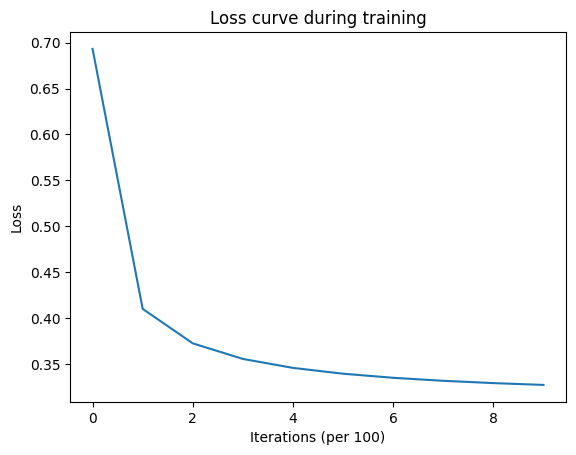

In [29]:
# Initialize parameters
w, b = initialize_parameters(X_train.shape[0])

# Train the model and store the loss at each iteration
parameters, grads, losses = optimize(w, b, X_train, y_train_binary, num_iterations=1000, learning_rate=0.01)

# Get the optimized parameters
w = parameters["w"]
b = parameters["b"]

# Make predictions on the training and test sets
y_pred_train = predict(w, b, X_train)
y_pred_test = predict(w, b, X_test)

# Evaluate the model
train_accuracy = 100 - np.mean(np.abs(y_pred_train - y_train_binary)) * 100
test_accuracy = 100 - np.mean(np.abs(y_pred_test - y_test_binary)) * 100

print(f"Train accuracy: {train_accuracy}%")
print(f"Test accuracy: {test_accuracy}%")

# Plot the loss after training
plt.plot(losses)
plt.ylabel('Loss')
plt.xlabel('Iterations (per 100)')
plt.title('Loss curve during training')
plt.show()


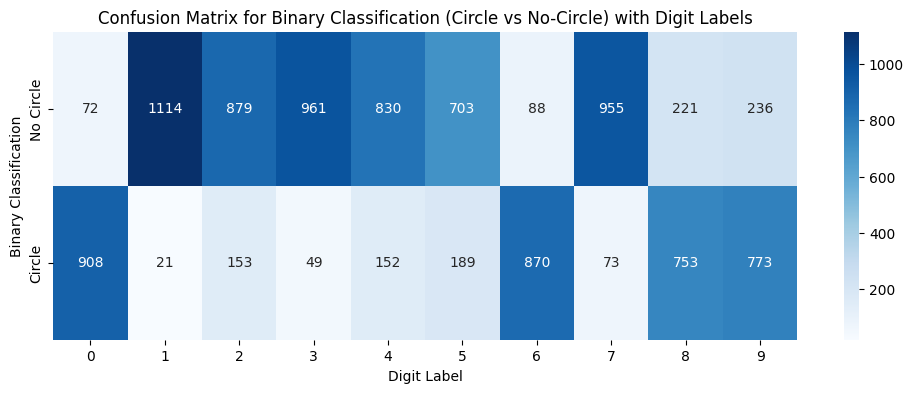

In [30]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


y_test_flat = y_test.flatten()
y_pred_test_flat = y_pred_test.flatten()

cm = np.zeros((2, 10), dtype=int) 

for i, true_label in enumerate(y_test_flat):
    predicted_binary = y_pred_test_flat[i]
    if predicted_binary == 1:  
        cm[1, true_label] += 1 # Predicted as a circle digit
    else:  
        cm[0, true_label] += 1  # Predicted as a no-circle digit

# Plot the confusion matrix
plt.figure(figsize=(12, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], yticklabels=['No Circle', 'Circle'])
plt.xlabel('Digit Label')
plt.ylabel('Binary Classification')
plt.title('Confusion Matrix for Binary Classification (Circle vs No-Circle) with Digit Labels')
plt.show()

## Let's compare our implementation to sklearn LogisticRegression

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X_train, y_train = load_mnist(mnist_path, kind='train')
X_test, y_test = load_mnist(mnist_path, kind='t10k')

X_train_sklearn = X_train  # Shape: (num_samples, num_features)
X_test_sklearn = X_test    # Shape: (num_samples, num_features)
y_train_sklearn = y_train.flatten()  # Shape: (num_samples,)
y_test_sklearn = y_test.flatten()    # Shape: (num_samples,)

# Train the logistic regression model using sklearn
model = LogisticRegression(solver='lbfgs', max_iter=1000, n_jobs=-1)
model.fit(X_train_sklearn, y_train_sklearn)

# Predict on the test set
y_pred = model.predict(X_test_sklearn)

# Evaluate the model
accuracy = accuracy_score(y_test_sklearn, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

: 

: 

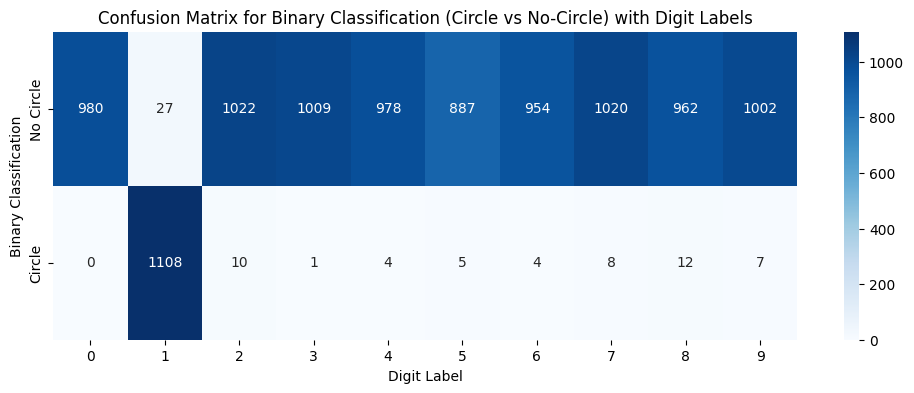

In [32]:
y_test_flat = y_test.flatten()
y_pred_test_flat = y_pred.flatten()

cm = np.zeros((2, 10), dtype=int) 

for i, true_label in enumerate(y_test_flat):
    predicted_binary = y_pred_test_flat[i]
    if predicted_binary == 1:  
        cm[1, true_label] += 1 # Predicted as a circle digit
    else:  
        cm[0, true_label] += 1  # Predicted as a no-circle digit

# Plot the confusion matrix
plt.figure(figsize=(12, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], yticklabels=['No Circle', 'Circle'])
plt.xlabel('Digit Label')
plt.ylabel('Binary Classification')
plt.title('Confusion Matrix for Binary Classification (Circle vs No-Circle) with Digit Labels')
plt.show()